# JAX Bellman Filter Debug

This notebook provides a minimal working example to debug the JAX-based Bellman filter implementation.

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from functions.simulation import DFSV_params, simulate_DFSV
from functions.bellman_filter import DFSVBellmanFilter

# Set random seed for reproducibility
np.random.seed(42)

# Create a minimal test model
K = 1  # Number of factors
N = 2  # Number of observed series

# Define model parameters
lambda_r = np.array([[1.0], [0.5]])  # Simple factor loadings
Phi_f = np.array([[0.7]])  # Factor persistence
Phi_h = np.array([[0.95]])  # Volatility persistence
mu = np.array([-1.0])  # Log-volatility mean
sigma2 = np.ones(N) * 0.1  # Measurement noise
Q_h = np.array([[1]])  # Volatility of log-volatility

# Create parameter object
params = DFSV_params(
    N=N, K=K, lambda_r=lambda_r, Phi_f=Phi_f, Phi_h=Phi_h, mu=mu, sigma2=sigma2, Q_h=Q_h
)

print("Model parameters created successfully")

Model parameters created successfully


In [4]:
# Generate synthetic data
T = 50  # Just a few time points for testing
y, factors, log_vols = simulate_DFSV(params, T=T, seed=42)

print("Data generated:")
print(f"y shape: {y.shape}")
print(f"factors shape: {factors.shape}")
print(f"log_vols shape: {log_vols.shape}")

Data generated:
y shape: (50, 2)
factors shape: (50, 1)
log_vols shape: (50, 1)


In [5]:
# Initialize the filter
try:
    bf = DFSVBellmanFilter(N, K)
    print("\nBellman filter initialized")
except Exception as e:
    print(f"Error during initialization: {e}")

JAX functions successfully precompiled

Bellman filter initialized


In [6]:
# Initialize state and test prediction step
try:
    # Initialize state
    state0, cov0 = bf.initialize_state(params)
    print(f"Initial state shape: {state0.shape}")
    print(f"Initial covariance shape: {cov0.shape}")
    print(f"\nInitial state:\n{state0}")

    # Test prediction step
    predicted_state, predicted_cov = bf.predict(params, state0, cov0)
    print("\nPrediction step completed")
    print(f"Predicted state:\n{predicted_state}")

    # Verify covariance matrices
    try:
        np.linalg.cholesky(predicted_cov)
        print("\nPredicted covariance is positive definite ✓")
    except np.linalg.LinAlgError:
        print("\nWARNING: Predicted covariance is not positive definite!")
        print("Eigenvalues:", np.linalg.eigvals(predicted_cov))
except Exception as e:
    print(f"Error during prediction: {e}")

Initial state shape: (2, 1)
Initial covariance shape: (2, 2)

Initial state:
[[ 0.]
 [-1.]]

Prediction step completed
Predicted state:
[ 0. -1.]

Predicted covariance is positive definite ✓


In [8]:
# jax.profiler.start_trace(log_dir=logdir)
observation = y[0:1, :].T.reshape(-1, 1)
print(f"Observation shape: {observation.shape}")
print(f"Observation values:\n{observation}")


updated_state, updated_cov, log_likelihood = bf.update(
    params, predicted_state, predicted_cov, observation
)


print("\nUpdate step completed")
print(f"Updated state:\n{updated_state}")
print(f"Log-likelihood: {log_likelihood}")

# Verify updated covariance
try:
    np.linalg.cholesky(updated_cov)
    print("\nUpdated covariance is positive definite ✓")
except np.linalg.LinAlgError:
    print("\nWARNING: Updated covariance is not positive definite!")
    print("Eigenvalues:", np.linalg.eigvals(updated_cov))
# jnp.array(updated_state).block_until_ready()
# jax.profiler.stop_trace()

Observation shape: (2, 1)
Observation values:
[[0.]
 [0.]]

Update step completed
Updated state:
[[ 0.        ]
 [-2.98518791]]
Log-likelihood: 0.21991969199967087

Updated covariance is positive definite ✓


In [9]:
# Debug run
y2, _, _ = simulate_DFSV(params, T=500, seed=42)
print("Running full filter...")

filtered_states, filtered_covs, log_likelihood = bf.filter(params, y2)
print("\nFilter completed successfully!")
print(f"Total log-likelihood: {log_likelihood}")
print(f"\nFiltered states shape: {filtered_states.shape}")
print(f"Filtered covs shape: {filtered_covs.shape}")

Running full filter...


Bellman Filter Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Filter completed successfully!
Total log-likelihood: -671.9522903595786

Filtered states shape: (500, 2)
Filtered covs shape: (500, 2, 2)


In [10]:
print("Running full filter...")

with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
    bf = DFSVBellmanFilter(N, K)
    print("\nBellman filter initialized,running full filter...")
    filtered_states, filtered_covs, log_likelihood = bf.filter(params, y)
print("\nFilter completed successfully!")
print(f"Total log-likelihood: {log_likelihood}")
print(f"\nFiltered states shape: {filtered_states.shape}")
print(f"Filtered covs shape: {filtered_covs.shape}")

# Compare with true states
print("\nCorrelation with true states:")
factor_corr = jnp.corrcoef(filtered_states[:, 0], factors[:, 0])[0, 1]
vol_corr = jnp.corrcoef(filtered_states[:, 1], log_vols[:, 0])[0, 1]
print(f"Factor correlation: {factor_corr:.4f}")
print(f"Log-volatility correlation: {vol_corr:.4f}")

Running full filter...


2025-03-18 15:25:53.444455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742307953.513364    4833 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742307953.526736    4833 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742307953.674000    4833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742307953.674022    4833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742307953.674023    4833 computation_placer.cc:177] computation placer alr

JAX functions successfully precompiled

Bellman filter initialized,running full filter...


Bellman Filter Progress:   0%|          | 0/50 [00:00<?, ?it/s]

OSError: [Errno 98] Address already in use

In [14]:
import time

bf = DFSVBellmanFilter(N, K)
bf2 = DFSVBellmanFilter(N, K)
# Time the JAX implementation
start_time = time.time()
filtered_states_jaxopt, filtered_covs_jaxopt, ll_jaxopt = bf.filter_scan(params, y)
jaxopt_time = time.time() - start_time
print(f"Optimized implementation time: {jaxopt_time:.4f} seconds")

# Time the original implementation
start_time = time.time()
filtered_states_orig, filtered_covs_orig, ll_orig = bf2.filter(params, y)
orig_time = time.time() - start_time
print(f"Original implementation time: {orig_time:.4f} seconds")

# Calculate speedup
speedup = orig_time / jaxopt_time if jaxopt_time > 0 else float("inf")
print(f"Speedup factor: {speedup:.2f}x")

# Compare results for consistency
states_diff = np.max(np.abs(filtered_states_jaxopt - filtered_states_orig))
covs_diff = np.max(np.abs(filtered_covs_jaxopt - filtered_covs_orig))
ll_diff = ll_jaxopt - ll_orig

print("\nResult consistency check:")
print(f"Max states difference: {states_diff:.8f}")
print(f"Max covariance difference: {covs_diff:.8f}")
print(f"Log-likelihood difference: {ll_diff:.8f}")

JAX functions successfully precompiled
JAX functions successfully precompiled
Optimized implementation time: 1.2537 seconds


Bellman Filter Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Original implementation time: 1.2497 seconds
Speedup factor: 1.00x

Result consistency check:
Max states difference: 0.00000000
Max covariance difference: 0.00000000
Log-likelihood difference: 0.00000000


In [ ]:
filtered_covs_jaxopt

array([[[0.11329213, 0.        ],
        [0.        , 5.79950001]],

       [[0.05350487, 0.        ],
        [0.        , 5.15446507]],

       [[0.03510596, 0.        ],
        [0.        , 5.09388643]],

       [[0.02655856, 0.        ],
        [0.        , 5.21928792]],

       [[0.0275698 , 0.        ],
        [0.        , 1.67070383]],

       [[0.32050274, 0.        ],
        [0.        , 1.33683287]],

       [[0.18325309, 0.        ],
        [0.        , 1.42474901]],

       [[0.11141073, 0.        ],
        [0.        , 1.6725007 ]],

       [[0.07562439, 0.        ],
        [0.        , 2.01014137]],

       [[0.05731626, 0.        ],
        [0.        , 2.30777978]],

       [[0.07158868, 0.        ],
        [0.        , 1.4073055 ]],

       [[0.22411746, 0.        ],
        [0.        , 1.35263399]],

       [[0.14090265, 0.        ],
        [0.        , 1.52425487]],

       [[0.10485425, 0.        ],
        [0.        , 1.64077499]],

       [[0.08365652,

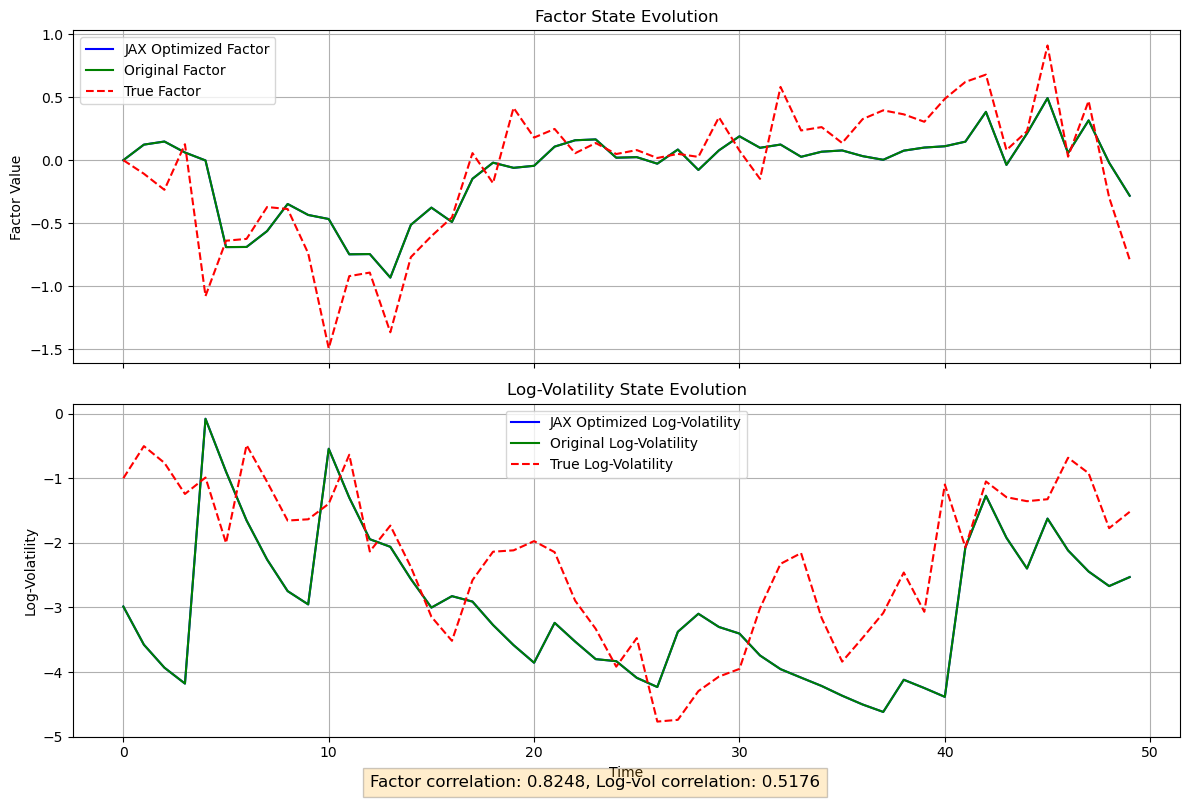

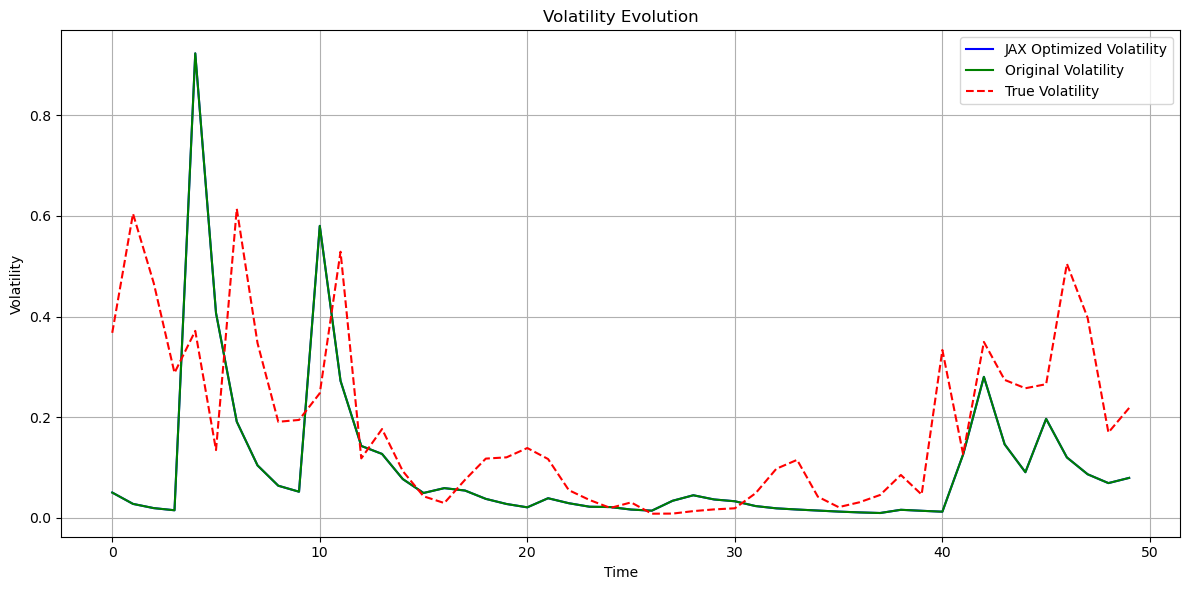

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot factor states
axes[0].plot(filtered_states_jaxopt[:, 0], "b-", label="JAX Optimized Factor")
axes[0].plot(filtered_states_orig[:, 0], "g-", label="Original Factor")
axes[0].plot(factors[:, 0], "r--", label="True Factor")
axes[0].set_title("Factor State Evolution")
axes[0].set_ylabel("Factor Value")
axes[0].grid(True)
axes[0].legend()

# Plot log-volatility states
axes[1].plot(filtered_states_jaxopt[:, 1], "b-", label="JAX Optimized Log-Volatility")
axes[1].plot(filtered_states_orig[:, 1], "g-", label="Original Log-Volatility")
axes[1].plot(log_vols[:, 0], "r--", label="True Log-Volatility")
axes[1].set_title("Log-Volatility State Evolution")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Log-Volatility")
axes[1].grid(True)
axes[1].legend()

# Also print the correlation values for reference
plt.figtext(
    0.5,
    0.01,
    f"Factor correlation: {factor_corr:.4f}, Log-vol correlation: {vol_corr:.4f}",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "orange", "alpha": 0.2, "pad": 5},
)

plt.tight_layout()
plt.show()

# Create a new figure for volatility (exp of log-volatility)
plt.figure(figsize=(12, 6))
plt.plot(np.exp(filtered_states_jaxopt[:, 1]), "b-", label="JAX Optimized Volatility")
plt.plot(np.exp(filtered_states_orig[:, 1]), "g-", label="Original Volatility")
plt.plot(np.exp(log_vols[:, 0]), "r--", label="True Volatility")
plt.title("Volatility Evolution")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(ll_jaxopt)

-32.47200353637212
